In [1570]:
# Install required packages
# %pip install matplotlib

# Imports
import os
import sys
import ast
import random
from collections import deque
import astunparse
import networkx as nx
from digraph_transformer import dataflow_parser
import matplotlib.pyplot as plt
from python_graphs.program_graph_dataclasses import EdgeType
from python_graphs import program_graph_dataclasses as pb  # For pb.Edge

print(sys.executable)

sys.path.append(os.path.abspath(".."))  # Zurück in das Hauptverzeichnis



/Users/florianhirt/PycharmProjects/Masterarbeit/interprete/bin/python


In [ ]:
# Code-Snippets of three f1 scores
code1 = """
def f1_score(pred, label):
    correct = pred == label
    tp = (correct & label).sum()
    fn = (~correct & pred).sum()
    fp = (~correct & ~pred).sum()
    if tp == 0:
        
        if fn == 0:
            return 1.0
        else:
            print("Error: Division by zero")
    else:
        fp = -fp
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    return (2 * (recall * precision) / (recall + precision))
"""

code2 = """
def f1_score(pred, label):
    correct = pred == label
    tp = (correct & label).sum()
    fn = (~correct & ~pred).sum()
    fp = (~correct & pred).sum()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    return (2 * (precision * recall) / (precision + recall))
"""

code3 = """
def f1_score(pred, label):
    correct = pred == label
    tp = (correct & label).sum()
    fn = (~correct & ~pred).sum()
    recall = tp / (tp + fn)
    fp = (~correct & pred).sum()
    precision = tp / (tp + fp)
    return (2 * (precision * recall) / (precision + recall))
"""

In [1572]:
# Code Snippet from the Appendix
simple_code = """
def transform_add(a, b: float = 3.14):
    a = a**2
    c = math.sqrt(b)
    return c + a
"""

In [1573]:
# Parse the ASTs
tree1 = ast.parse(code1)
tree2 = ast.parse(code2)
tree3 = ast.parse(code3)
simple_tree = ast.parse(simple_code)

# Extract the Function Bodies
function_body1 = tree1.body[0].body
function_body2 = tree2.body[0].body
function_body3 = tree3.body[0].body
simple_body = simple_tree.body[0].body

In [1574]:
# Function for detailed output of the AST nodes
def print_ast_details(body, label):
    print(f"{label}:\n")
    for stmt in body:
        print(ast.dump(stmt, annotate_fields=True, include_attributes=True))
    print("\n" + "=" * 50 + "\n")

In [1575]:
def non_deterministic_topological_sort(graph):
    # Check if DAG
    pos = nx.spring_layout(graph, seed=225)  # Seed for reproducible layout
    nx.draw(graph, pos)
    plt.show()

    if not nx.is_directed_acyclic_graph(graph):
        raise ValueError("Graph contains a cycle!")

    graph_copy = graph.copy()
    topo_order = []

    # Find nodes with no incoming edges (sources)
    sources = deque([node for node in graph_copy.nodes if graph_copy.in_degree(node) == 0])

    while sources:
        # Select a source node randomly and add it to topo_order
        random_index = random.randint(0, len(sources) - 1)
        node = sources[random_index]
        sources.remove(node)
        topo_order.append(node)

        # Remove the node from the graph and update sources
        successors = list(graph_copy.successors(node))
        random.shuffle(successors)

        for successor in successors:
            graph_copy.remove_edge(node, successor)
            if graph_copy.in_degree(successor) == 0:
                sources.append(successor)

        # Remove the processed node from the graph
        graph_copy.remove_node(node)

    return topo_order


In [1576]:
class ASTReconstructor(ast.NodeTransformer):
    def __init__(self, graph, topo_sort):
        self.graph = graph
        self.topo_sort = topo_sort
        self.ast_map = {node_id: graph.nodes[node_id].ast_node for node_id in topo_sort}
        self.reconstructed_body = []

    def visit_FunctionDef(self, node):
        # Recursive sorting for the body of a function
        node.body = self.reorder_body(node.body)
        return node

    def reorder_body(self, body):
        # Filter the nodes of the current body and sort them by topological order
        print("Jetzt")
        body_ids = [id(stmt) for stmt in body if isinstance(stmt, ast.stmt)]
        reordered_body = [self.ast_map[node_id] for node_id in self.topo_sort if id(self.ast_map[node_id]) in body_ids]
        return reordered_body

def graph_to_ast(graph, topo_sort):
    # Use the first node of the AST according to the topo_sort as the starting point
    first_node_id = topo_sort[0]
    root_node = graph.nodes[first_node_id].ast_node

    # Use the ASTReconstructor
    reconstructor = ASTReconstructor(graph, topo_sort)
    reconstructor.visit(root_node)

    return root_node

In [1577]:
class ASTOrder(ast.NodeVisitor):
    def __init__(self, graph):
        self.index = 0
        self.node_to_order = {}
        self.graph = graph

    def visit(self, node):
        self.node_to_order[id(node)] = self.index
        self.index += 1
        self.generic_visit(node)

    def reorder_graph(self):
        edges_to_remove = []
        for edge in self.graph.edges:
            if (self.node_to_order[id(self.graph.nodes[edge.id1].ast_node)] > self.node_to_order[id(self.graph.nodes[edge.id2].ast_node)]) or (edge.id1 == edge.id2):
                edges_to_remove.append(edge)
        
        for edge in edges_to_remove:
            self.graph.edges.remove(edge)


Dependencies, die von außerhalb eines If-Blocks in einen If-Block Zeigen, müssen auch auf höheren Ebenen sichtbar gemacht werden!

In [1578]:
def add_control_block_dependencies(graph):
    # TODO: Mit graph-traversal Ifs in Ifs finden
    # Child if auf die parents propagaten  (wenn if in if)
    for node_id in graph.nodes:
        ast_node = graph.get_node(node_id).ast_node
        if ast_node.__class__.__name__ == "If":
            # Collect all nodes inside the If body
            body_node_ids = [graph.get_node_by_ast_node(stmt).id for stmt in ast_node.body]
            orelse_node_ids = [graph.get_node_by_ast_node(stmt).id for stmt in ast_node.orelse]

            # Collect the node for the If condition (test)
            test_node_id = graph.get_node_by_ast_node(ast_node.test).id

            # Combine body, orelse, and test as the If block
            if_block_nodes = set(body_node_ids + orelse_node_ids + [test_node_id])

            print(f"If block nodes: {body_node_ids.__str__()}")
            print(f"If-else block nodes: {if_block_nodes.__str__()}")
            node_names = [graph.get_node(node_id).ast_node.__class__.__name__ for node_id in if_block_nodes]
            print(f"Node names in If block: {node_names}")

            # Check dependencies for each inner node
            for inner_node_id in if_block_nodes:
                for edge in graph.edges:
                    if edge.id2 == inner_node_id:  # Check if there is an incoming dependency
                        if edge.id1 not in if_block_nodes and edge.id1 != node_id:  # From outside the If block and not the If node itself
                            # Create a pb.Edge object
                            new_edge = pb.Edge(id1=edge.id1, id2=node_id, type=edge.type)
                            if not any(e.id1 == new_edge.id1 and e.id2 == new_edge.id2 and e.type == new_edge.type for e in graph.edges):
                                graph.add_edge(new_edge)
                                print(f"Added edge: {new_edge}")
                                node1_name = graph.get_node(new_edge.id1).ast_node.__class__.__name__
                                node2_name = graph.get_node(new_edge.id2).ast_node.__class__.__name__
                                print(f"Edge connects node {new_edge.id1} ({node1_name}) to node {new_edge.id2} ({node2_name})")



        elif ast_node.__class__.__name__ == "For":
            # Collect all nodes inside the For body
            body_node_ids = [graph.get_node_by_ast_node(stmt).id for stmt in ast_node.body]
            orelse_node_ids = [graph.get_node_by_ast_node(stmt).id for stmt in ast_node.orelse]

            # Collect the node for the For target and iter (loop variable and iterable)
            target_node_id = [graph.get_node_by_ast_node(ast_node.target).id]
            iter_node_id = [graph.get_node_by_ast_node(ast_node.iter).id]

            # Combine body, orelse, target, and iter as the For block
            for_block_nodes = set(body_node_ids + orelse_node_ids + target_node_id + iter_node_id)

            print(f"For block nodes: {body_node_ids.__str__()}")
            print(f"For-else block nodes: {for_block_nodes.__str__()}")
            node_names = [graph.get_node(node_id).ast_node.__class__.__name__ for node_id in for_block_nodes]
            print(f"Node names in For block: {node_names}")

            # Check dependencies for each inner node
            for inner_node_id in for_block_nodes:
                for edge in graph.edges:
                    if edge.id2 == inner_node_id:  # Check if there is an incoming dependency
                        if edge.id1 not in for_block_nodes and edge.id1 != node_id:  # From outside the For block and not the For node itself
                            # Create a pb.Edge object
                            new_edge = pb.Edge(id1=edge.id1, id2=node_id, type=edge.type)
                            if not any(e.id1 == new_edge.id1 and e.id2 == new_edge.id2 and e.type == new_edge.type for e in graph.edges):
                                graph.add_edge(new_edge)
                                print(f"Added edge: {new_edge.__str__()}")
                                node1_name = graph.get_node(new_edge.id1).ast_node.__class__.__name__
                                node2_name = graph.get_node(new_edge.id2).ast_node.__class__.__name__
                                print(f"Edge connects node {new_edge.id1} ({node1_name}) to node {new_edge.id2} ({node2_name})")


In [1579]:
print_ast_details(function_body1, "Code")

Code:

Assign(targets=[Name(id='correct', ctx=Store(), lineno=3, col_offset=4, end_lineno=3, end_col_offset=11)], value=Compare(left=Name(id='pred', ctx=Load(), lineno=3, col_offset=14, end_lineno=3, end_col_offset=18), ops=[Eq()], comparators=[Name(id='label', ctx=Load(), lineno=3, col_offset=22, end_lineno=3, end_col_offset=27)], lineno=3, col_offset=14, end_lineno=3, end_col_offset=27), lineno=3, col_offset=4, end_lineno=3, end_col_offset=27)
Assign(targets=[Name(id='tp', ctx=Store(), lineno=4, col_offset=4, end_lineno=4, end_col_offset=6)], value=Call(func=Attribute(value=BinOp(left=Name(id='correct', ctx=Load(), lineno=4, col_offset=10, end_lineno=4, end_col_offset=17), op=BitAnd(), right=Name(id='label', ctx=Load(), lineno=4, col_offset=20, end_lineno=4, end_col_offset=25), lineno=4, col_offset=10, end_lineno=4, end_col_offset=25), attr='sum', ctx=Load(), lineno=4, col_offset=9, end_lineno=4, end_col_offset=30), args=[], keywords=[], lineno=4, col_offset=9, end_lineno=4, end_col_

In [1580]:
graph, tree1 = dataflow_parser.get_program_graph(code1)

ast_map = {id(graph.nodes[node_id].ast_node): node_id for node_id in graph.nodes}

# Filter edge type 9 as this represents the sequential connections of the original code
graph.edges = [e for e in graph.edges if e.type.value != 9]

In [1581]:
add_control_block_dependencies(graph)

If block nodes: [13204676197037988948]
If-else block nodes: {12808025572266286531, 13204676197037988948, 13525390124097217516}
Node names in If block: ['Assign', 'If', 'Compare']
Added edge: Edge(id1=13633802182989808470, id2=13229793189410502512, type=<EdgeType.CFG_NEXT: 1>, field_name=None, has_back_edge=False)
Edge connects node 13633802182989808470 (Assign) to node 13229793189410502512 (If)
Added edge: Edge(id1=12734023408023874452, id2=13229793189410502512, type=<EdgeType.CFG_NEXT: 1>, field_name=None, has_back_edge=False)
Edge connects node 12734023408023874452 (Assign) to node 13229793189410502512 (If)
Added edge: Edge(id1=10572875439731379629, id2=13229793189410502512, type=<EdgeType.CFG_NEXT: 1>, field_name=None, has_back_edge=False)
Edge connects node 10572875439731379629 (Assign) to node 13229793189410502512 (If)
If block nodes: [13704821075185104644]
If-else block nodes: {13704821075185104644, 9340670671254471371, 13724007071784316964}
Node names in If block: ['Return', 'Co

In [1582]:
ast_order = ASTOrder(graph)
ast_order.visit(tree1)

# Reorder the graph to drop cycles
ast_order.reorder_graph()

In [1583]:
print("Nodes: \n",graph.nodes,"\n")
print("Edges: \n", graph.edges, "\n")
print(edge for edge in graph.edges if egde.type.value == 9)

Nodes: 
 {9706777485678915276: 9706777485678915276 FunctionDef, 9286084616603500481: 9286084616603500481 arguments, 11173184363082442222: 11173184363082442222 Assign, 13633802182989808470: 13633802182989808470 Assign, 12734023408023874452: 12734023408023874452 Assign, 10572875439731379629: 10572875439731379629 Assign, 13525390124097217516: 13525390124097217516 Compare, 9340670671254471371: 9340670671254471371 Compare, 13704821075185104644: 13704821075185104644 Return, 13724007071784316964: 13724007071784316964 Expr, 12808025572266286531: 12808025572266286531 Assign, 10346658004776722186: 10346658004776722186 Assign, 11408015204692898436: 11408015204692898436 Assign, 12698556483812439716: 12698556483812439716 Return, 12625395947665722563: 12625395947665722563 Module, 13229793189410502512: 13229793189410502512 If, 12991235564516337667: 12991235564516337667 Name, 12420180583624487302: 12420180583624487302 Name, 11367048473149461240: 11367048473149461240 Name, 10331256216380061911: 1033125

In [1584]:
# Create a new directed graph
nx_graph = nx.DiGraph()

# Add nodes
nx_graph.add_nodes_from(graph.nodes.keys())

# Add edges with only id1 and id2
edges = [(edge.id1, edge.id2) for edge in graph.edges]
nx_graph.add_edges_from(edges)


In [1585]:
tree1.body[0].body[1]

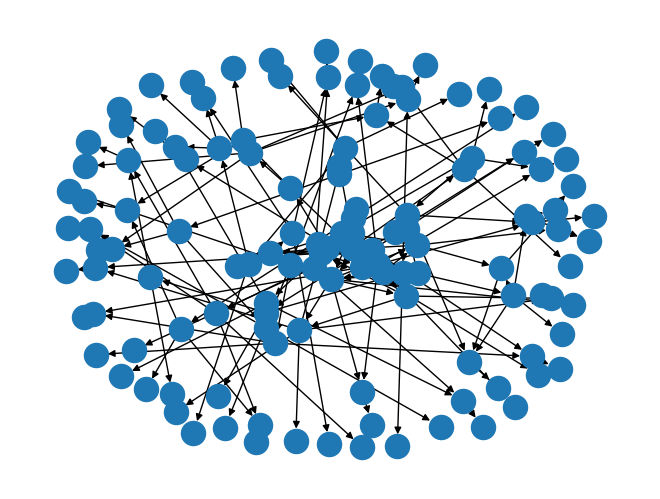

In [1586]:
if nx.is_directed_acyclic_graph(nx_graph):
    topo_sort = non_deterministic_topological_sort(nx_graph)
else:
    print("The graph contains a cycle and cannot be topologically sorted.")
    try:
        cycle = nx.find_cycle(nx_graph, orientation='original')
        print("Cycle found in the graph:", cycle)
        if cycle:
            pos = nx.spring_layout(nx_graph, seed=225)
            plt.figure(figsize=(12, 8))
            nx.draw(nx_graph, pos, with_labels=True, node_color='lightblue', edge_color='gray')
            cycle_edges = [(u, v) for u, v, _ in cycle]
            nx.draw_networkx_edges(nx_graph, pos, edgelist=cycle_edges, edge_color='r', width=2)
            node1_name = graph.get_node(cycle[0][0]).ast_node.__class__.__name__
            node2_name = graph.get_node(cycle[0][1]).ast_node.__class__.__name__ if len(cycle) > 1 else "N/A"
            # Print detailed information about the nodes in the cycle
            for u, v in cycle_edges:
                node_u = graph.get_node(u)
                node_v = graph.get_node(v)
                print(f"Edge from {node_u.ast_node.__class__.__name__} to {node_v.ast_node.__class__.__name__}")
                print(f"Node {u} details: {ast.dump(node_u.ast_node, annotate_fields=True, include_attributes=True)}")
                print(f"Node {v} details: {ast.dump(node_v.ast_node, annotate_fields=True, include_attributes=True)}")

            # Handle self-cycle
            if len(cycle) == 1:
                node_u = graph.get_node(cycle[0][0])
                print(f"Self-cycle detected at node {node_u.ast_node.__class__.__name__}")
                print(f"Node details: {ast.dump(node_u.ast_node, annotate_fields=True, include_attributes=True)}")

            plt.show()
        else:
            print("No cycle found in the graph.")
    except nx.NetworkXNoCycle:
        print("No cycle found in the graph.")
        

In [1587]:
# Get the node IDs for the Assign and If nodes
assign_node_id = ast_map.get(id(tree1.body[0].body[0]))
print(tree1.body[0].body[0])
if_node_id = ast_map.get(id(tree1.body[0].body[1]))
print(tree1.body[0].body[1])

# Check if the node IDs were found
if assign_node_id is None or if_node_id is None:
	print("One of the node IDs was not found in the ast_map.")
else:
	# Check if there is an edge from the Assign node to the If node
	edge_exists = any(edge.id1 == assign_node_id and edge.id2 == if_node_id for edge in graph.edges)

	print(f"Edge from 'correct = (pred == label)' to 'if (correct < 3): print(correct) else: print('ABC')' exists: {edge_exists}")
	# Check for all edges that go into the node that represents the If statement
	incoming_edges = [edge for edge in graph.edges if edge.id2 == if_node_id]

	print(f"Incoming edges to the 'if (correct < 3): print(correct) else: print('ABC')' node: {incoming_edges}")
	# Get the names of the nodes that have an edge pointing to the If node
	incoming_node_names = [graph.nodes[edge.id1].ast_node.__class__.__name__ for edge in incoming_edges]

	print(f"Nodes with edges pointing to the 'if (correct < 3): print(correct) else: print('ABC')' node: {incoming_node_names}")

Edge from 'correct = (pred == label)' to 'if (correct < 3): print(correct) else: print('ABC')' exists: True
Incoming edges to the 'if (correct < 3): print(correct) else: print('ABC')' node: [Edge(id1=9706777485678915276, id2=13633802182989808470, type=<EdgeType.FIELD: 7>, field_name='body:1', has_back_edge=False), Edge(id1=11173184363082442222, id2=13633802182989808470, type=<EdgeType.CFG_NEXT: 1>, field_name=None, has_back_edge=False)]
Nodes with edges pointing to the 'if (correct < 3): print(correct) else: print('ABC')' node: ['FunctionDef', 'Assign']


In [1588]:
tree1.body[0].body[1]

In [1589]:
print(astunparse.unparse(tree1))



def f1_score(pred, label):
    correct = (pred == label)
    tp = (correct & label).sum()
    fn = ((~ correct) & pred).sum()
    fp = ((~ correct) & (~ pred)).sum()
    if (tp == 0):
        if (fn == 0):
            return 1.0
        else:
            print('Error: Division by zero')
    else:
        fp = (- fp)
    precision = (tp / (tp + fp))
    recall = (tp / (tp + fn))
    return ((2 * (recall * precision)) / (recall + precision))



In [1590]:
reconstructed_ast = graph_to_ast(graph, topo_sort)
generated_code = astunparse.unparse(reconstructed_ast)
print(generated_code)

Jetzt


def f1_score(pred, label):
    correct = (pred == label)
    fn = ((~ correct) & pred).sum()
    tp = (correct & label).sum()
    fp = ((~ correct) & (~ pred)).sum()
    if (tp == 0):
        if (fn == 0):
            return 1.0
        else:
            print('Error: Division by zero')
    else:
        fp = (- fp)
    precision = (tp / (tp + fp))
    recall = (tp / (tp + fn))
    return ((2 * (recall * precision)) / (recall + precision))



In [1591]:
original_nodes_list = list(graph.nodes.keys())
index_sort = [original_nodes_list.index(node_id) for node_id in topo_sort]

print("Topological Sort as Indexes:", index_sort)

Topological Sort as Indexes: [14, 0, 1, 2, 17, 18, 4, 16, 34, 33, 22, 40, 19, 36, 32, 3, 20, 21, 23, 5, 25, 43, 41, 64, 67, 95, 66, 35, 60, 98, 94, 39, 97, 38, 115, 62, 24, 65, 118, 42, 119, 96, 15, 99, 93, 91, 121, 6, 114, 46, 26, 127, 63, 113, 37, 116, 92, 44, 61, 117, 10, 125, 126, 120, 45, 7, 70, 69, 71, 100, 8, 72, 48, 76, 9, 73, 75, 68, 11, 101, 27, 102, 103, 28, 51, 47, 52, 50, 79, 78, 74, 122, 49, 77, 104, 80, 105, 12, 13, 31, 58, 30, 54, 59, 81, 89, 90, 56, 84, 82, 106, 112, 57, 107, 29, 86, 55, 87, 53, 108, 123, 110, 109, 83, 85, 88, 111, 124]
